In [260]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
from pandas.api.types import CategoricalDtype

import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, ElasticNet 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

import math 

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 150)

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

In [261]:
# FUNCTION WHICH CREATES DF READY FOR REGRESSION, SCALED WITH DUMMY VARIABLES
def scale_bin_df(df, target, droplist):
    # numerical X variables without target
    df = df.drop(droplist, axis=1)
    num_list = list(df.loc[:, (df.dtypes == np.float64)].columns)
    num_list.remove(target)
    X_cols = df.drop(target, axis=1)

    # scale numerical variables
    X_scaled = X_cols.copy()
    scaler = StandardScaler()
    X_scaled[num_list] = scaler.fit_transform(X_cols[num_list])

    # create dummy variables
    Xdum = pd.get_dummies(X_scaled, drop_first=True)

    # dataframe for regression
    finaldf = Xdum.copy()
    finaldf[target] = df[target]

    # remove spaces in column names
    for char in [' ', '.', '-', '/']:
        finaldf.columns = finaldf.columns.str.replace(char, '_')
        
    return finaldf


# FUNCTION WHICH SHOWS VARIANCE INFLATION FACTOR GIVEN A DATAFRAME  
def vif_scores(df, y): 
    def formula_from_cols(df, y):
        return (y + ' ~ ' + ' + '.join([col for col in df.columns if not col==y]))
    formula = formula_from_cols(df, y)
    y, X = dmatrices(formula_like=formula, data=df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif = vif.sort_values(["VIF Factor"], ascending=False)
    vif = vif.iloc[1:] #dropping intercept
    return vif

#LINEAR REGRESSION FUNCTION
def linreg(X, y, type): 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=30)
    
    reg_all=LinearRegression()
    reg_all.fit(X_train, y_train)
    
    y_test_pred = reg_all.predict(X_test)
    y_train_pred = reg_all.predict(X_train)
    print('Training R^2: %.4f' % r2_score(y_train, y_train_pred))
    print('Testing R^2: %.4f' % r2_score(y_test, y_test_pred))
    
    if type == 'log':
        dollarpred = np.array([math.exp(np.log(10)*i) for i in y_test_pred])
        dollary = np.array([math.exp(np.log(10)*i) for i in y_test])
        mape = np.mean(np.abs(dollarpred - dollary)/dollary)*100
        print("Testing RMSE: %.2f"
          % (np.sqrt(mean_squared_error(dollary, dollarpred))))
        print("MAPE:", np.round(mape,2))
    else:
        rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        errors = abs(y_test_pred - y_test)
        mape = np.mean(errors / y_test)*100
        print("Testing RMSE: %.2f" % (rmse))
        print("MAPE: %.2f" % (mape))

    
#RIDGE REGRESSION FUNCTION
def ridgereg(X, y, type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(0, 1, 10)
    param_grid = {'alpha': space}
    
    ridge = Ridge()
    gm_cv = GridSearchCV(ridge, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    tr_r2 = gm_cv.score(X_train, y_train)
    print("Training RIDGE R^2: %.4f" % (tr_r2))
    print("Testing RIDGE R^2: %.4f" % (r2))
    print("Tuned RIDGE alpha: {}".format(gm_cv.best_params_))
    
    if type == 'log':
        dollarpred = np.array([math.exp(np.log(10)*i) for i in y_pred])
        dollary = np.array([math.exp(np.log(10)*i) for i in y_test])
        mape = np.mean(np.abs(dollarpred - dollary)/dollary)*100
        print("Testing RMSE: %.2f"
          % (np.sqrt(mean_squared_error(dollary, dollarpred))))
        print("MAPE:", np.round(mape,2))
    else:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        errors = abs(y_pred - y_test)
        mape = np.mean(errors / y_test)*100
        print("Testing RMSE: %.2f" % (rmse))
        print("MAPE: %.2f" % (mape))
    
    
# LASSO REGRESSION FUNCTION
def lassoreg(X, y, type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(.05, 1, 5)
    param_grid = {'alpha': space}
    
    lasso = Lasso()
    gm_cv = GridSearchCV(lasso, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    tr_r2 = gm_cv.score(X_train, y_train)
    print("Training LASSO R^2: %.4f" % (tr_r2))
    print("Testing LASSO R^2: %.4f" % (r2))
    print("Tuned LASSO alpha: {}".format(gm_cv.best_params_))
    
    if type == 'log':
        dollarpred = np.array([math.exp(np.log(10)*i) for i in y_pred])
        dollary = np.array([math.exp(np.log(10)*i) for i in y_test])
        mape = np.mean(np.abs(dollarpred - dollary)/dollary)*100
        print("Testing RMSE: %.4f"
          % (np.sqrt(mean_squared_error(dollary, dollarpred))))
        print("MAPE:", np.round(mape,2))
    else:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        errors = abs(y_pred - y_test)
        mape = np.mean(errors / y_test)*100
        print("Testing RMSE: %.4f" % (rmse))
        print("MAPE: %.2f" % (mape))

# ELASTICNET REGRESSION FUNCTION
def elasticnet(X, y, type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
    space = np.linspace(.05, 1, 4)
    param_grid = {'l1_ratio': space, 'alpha': space}
    
    elastic_net = ElasticNet()
    gm_cv = GridSearchCV(elastic_net, param_grid, cv=5)
    gm_cv.fit(X_train, y_train)

    y_pred = gm_cv.predict(X_test)
    r2 = gm_cv.score(X_test, y_test)
    tr_r2 = gm_cv.score(X_train, y_train)
    print("Training ElasticNet R^2: %.4f" % (tr_r2))
    print("Testing ElasticNet R^2: %.4f" % (r2))
    print("Tuned ElasticNet l1 ratio: {}".format(gm_cv.best_params_))
    
    if type == 'log':
        dollarpred = np.array([math.exp(np.log(10)*i) for i in y_pred])
        dollary = np.array([math.exp(np.log(10)*i) for i in y_test])
        mape = np.mean(np.abs(dollarpred - dollary)/dollary)*100
        print("Testing RMSE: %.4f"
          % (np.sqrt(mean_squared_error(dollary, dollarpred))))
        print("MAPE:", np.round(mape,2))
    else:
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        errors = abs(y_pred - y_test)
        mape = np.mean(errors / y_test)*100
        print("Testing RMSE: %.4f" % (rmse))
        print("MAPE: %.2f" % (mape))
    
    
    
    
    
# QUICK CHECK RMSE FUNCTION: 
# CHECK RMSE FOR MODELS BASED ON DIFFERENT SUBSETS OF VARIABLES FOR REGRESSION
def scale_rmse_df(df, target, droplist, type):
    # numerical X variables without target
    df = df.drop(droplist, axis=1)
    num_list = list(df.loc[:, (df.dtypes == np.float64)].columns)
    num_list.remove(target)
    X_cols = df.drop(target, axis=1)

    # scale numerical variables
    X_scaled = X_cols.copy()
    scaler = StandardScaler()
    X_scaled[num_list] = scaler.fit_transform(X_cols[num_list])

    # create dummy variables
    Xdum = pd.get_dummies(X_scaled, drop_first=True)

    # dataframe for regression
    finaldf = Xdum.copy()
    finaldf[target] = df[target]

    # remove spaces in column names
    for char in [' ', '.', '-', '/']:
        finaldf.columns = finaldf.columns.str.replace(char, '_')
    
    if 'EXTWALL_Plywood' in finaldf.columns:
        finaldf = finaldf.drop(['EXTWALL_Plywood'], axis=1) #preventing glitch

    X = finaldf.drop([target], axis=1).values
    y = finaldf[target].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=30)
    
    reg_all=LinearRegression()
    reg_all.fit(X_train, y_train)
    
    y_test_pred = reg_all.predict(X_test)
    y_train_pred = reg_all.predict(X_train)
    print('Training R^2: %.4f' % r2_score(y_train, y_train_pred))
    print('Testing R^2: %.4f' % r2_score(y_test, y_test_pred))
    
    if type == 'log':
        dollarpred = np.array([math.exp(np.log(10)*i) for i in y_test_pred])
        dollary = np.array([math.exp(np.log(10)*i) for i in y_test])
        mape = np.mean(np.abs(dollarpred - dollary)/dollary)*100
        print("Testing RMSE:': %.2f"
          % (np.sqrt(mean_squared_error(dollary, dollarpred))))
        print("MAPE:", np.round(mape,2))
    else:
        errors = abs(y_test_pred - y_test)
        mape = np.mean(errors / y_test)*100
        print("Testing RMSE: %.2f"
          % (np.sqrt(mean_squared_error(y_test, y_test_pred))))
        print("Testing MAPE: %.2f" % (mape))
        return finaldf.head()


In [262]:
finaldf = pd.read_csv('/Users/Julia/Documents/bootcamp/DC_capstone/finaldf.csv', low_memory=False)
#removing properties with no price
finaldf = finaldf[(finaldf['PRICE'] > 0)]
finaldf.reset_index(drop=True, inplace=True)
finaldf.head()

,PRICE,SALE_DATE,SALE_NUM,QUALIFIED,QUADRANT,WARD,SQUARE,NBHD,SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,ZIPCODE,LATITUDE,LONGITUDE,STYLE,STRUCT,USECODE,UNITS,STORIES,GRADE,CNDTN,LANDAREA,GBA,GBA_LIVING,YR_ORIGIN,YR_EXT,YR_RMDL,ROOMS,BEDRMS,BATHRMS,KITCHENS,HEAT,AC,FIREPLACES,ROOF,INTWALL,EXTWALL
0,1095000.0,2003-11-25 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914680,-77.040832,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Good,1680.0,2522.0,700.0,1910.0,1972.0,1988.0,8.0,4.0,4.0,2.0,Warm Cool,Y,5.0,Metal- Sms,Hardwood,Common Brick
1,2100000.0,2016-06-21 00:00:00,3.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914684,-77.040678,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Very Good,1680.0,2522.0,700.0,1910.0,1984.0,2009.0,9.0,5.0,3.5,2.0,Hot Water Rad,Y,4.0,Built Up,Hardwood,Common Brick
2,1602000.0,2006-07-12 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914683,-77.040629,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Good,1680.0,2484.0,700.0,1900.0,1984.0,2003.0,8.0,5.0,3.5,2.0,Hot Water Rad,Y,3.0,Built Up,Hardwood,Common Brick
3,1950000.0,2010-02-26 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2006,20009.0,38.914331,-77.039715,4 Story,Row Inside,11.0,1.0,4.0,Very Good,Good,2196.0,5344.0,700.0,1913.0,1972.0,2007.0,10.0,5.0,4.0,1.0,Hot Water Rad,Y,4.0,Built Up,Hardwood,Common Brick
4,1050000.0,2011-09-29 00:00:00,1.0,Q,NW,Ward 2,152,Old City 2,040 D Old City 2,4201,004201 2005,20009.0,38.915408,-77.040129,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Average,1627.0,2401.0,700.0,1906.0,1972.0,2011.0,8.0,4.0,3.5,2.0,Hot Water Rad,Y,1.0,Metal- Sms,Hardwood,Common Brick


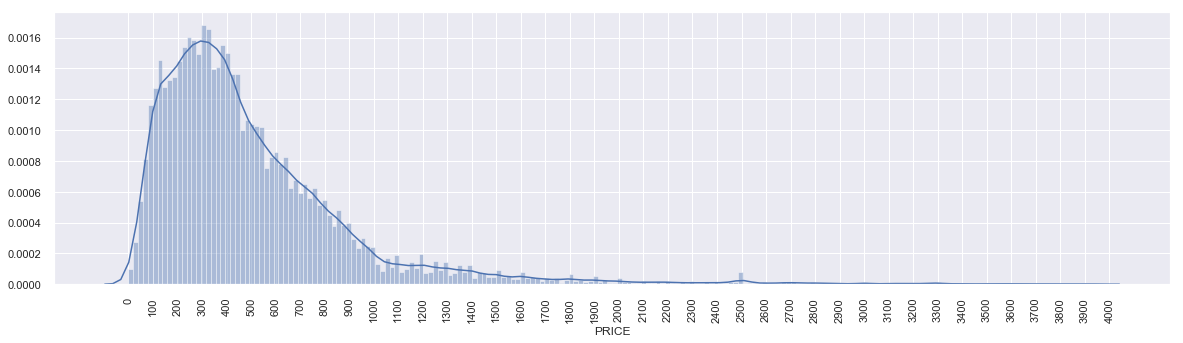

In [263]:
# price distribution

sns.set()

plt.figure(figsize=(20, 5))
h = sns.distplot(finaldf.PRICE/1000, bins=200)
h.set(xticks = list(np.arange(0, 4100, 100)))
plt.xticks(rotation=90)

plt.show()

In [264]:
quants = [.005, .05, .1, .25, .5, .75, .9, .95, .995]
percsq = list(np.quantile(np.round(finaldf.PRICE/1000), quants))
preddf = pd.DataFrame({'Quantile': quants, 'Price in thousands': percsq})
preddf

,Quantile,Price in thousands
0,0.005,32.00
1,0.050,93.00
2,0.100,130.00
3,0.250,239.00
4,0.500,400.00
5,0.750,647.00
6,0.900,935.00
7,0.950,1265.00
8,0.995,2610.68


In [265]:
len_low = len(finaldf[finaldf.PRICE < 35000])
len_high = len(finaldf[finaldf.PRICE > 2500000])
len_total = len(finaldf)
print("Number of low outliers:", len_low)
print("Number of high outliers:", len_high)
print("Amount of data lost:", np.round(((len_low + len_high)/len_total*100), 2), "%.")

Number of low outliers: 548
Number of high outliers: 551
Amount of data lost: 1.13 %.


### We will remove the most extreme values from PRICE. 
### Our model will predict property values between 35,000 and 2,500,000

In [266]:
#removing properties with no price
finaldf = finaldf[((finaldf['PRICE'] >= 35000) & (finaldf['PRICE'] <= 2500000))]
finaldf.reset_index(drop=True, inplace=True)

In [267]:
# MODIFICATIONS

#new dataframe with timestamp instead of datetime for SALE_DATE
finaldf.SALE_DATE = pd.to_datetime(finaldf.SALE_DATE)

times = []
for i in finaldf['SALE_DATE']:
    times.append(datetime.timestamp(i))
finaldf['SALE_DATE'] = times
    
#dropping LATITUDE and LONGITUDE because these values zig-zag between properties.
#dropping CENSUS_TRACT because it's included in CENSUS_BLOCK.
dropdf = finaldf.drop(['LATITUDE', 'LONGITUDE', 'CENSUS_TRACT'], axis=1)

#remove spaces
strips=dropdf['CENSUS_BLOCK'].apply(str).str.replace(" ", "")
dropdf['CENSUS_BLOCK'] = strips

#change numerical to categorical
for col in ['SALE_NUM', 'SQUARE', 'CENSUS_BLOCK', 'USECODE', 'ZIPCODE']:
    dropdf[col] = dropdf[col].astype('category')


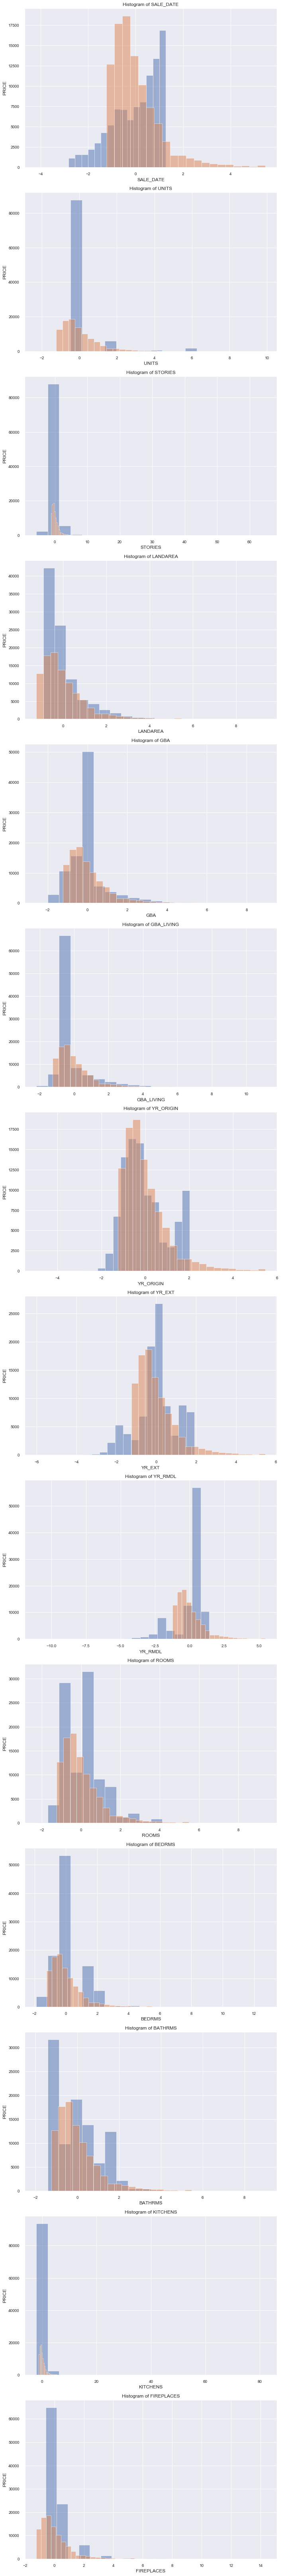

In [268]:
# CHECKING DISTRIBUTIONS
# it does not appear that the variables would benefit from transformations.

def hist_all(df, target):
    #scaling numerical cols
    num_list = list(df.loc[:, (df.dtypes == np.float64)].columns)
    scaledf = pd.DataFrame()
    for col in num_list:
        scaledf[col] = (df[col] - np.mean(df[col])) / np.std(df[col])
    num_list.remove(target)
    
    #histograms for numerical facets
    fig, axs = plt.subplots(len(scaledf.columns)-3,1, figsize=(10,6*len(scaledf.columns)))
    plt.rc('xtick', labelsize='small') 
    plt.rc('ytick', labelsize='small') 
    for i, name in enumerate(num_list):
        if (str(name) != target):
            plt.subplot(len(num_list), 1, i+1)
            a = plt.hist(scaledf[name], alpha=.5, bins=20)
            a = plt.hist(scaledf[target], alpha=.5, bins=20)
            plt.xlabel(name)
            plt.ylabel(target)
            plt.title("Histogram of %s" % name)  
    plt.tight_layout()

hist_all(dropdf, 'PRICE')

In [269]:
# CORRELATION MATRIX

num_df = dropdf.loc[:, (dropdf.dtypes == np.float64)]
num_df.drop('PRICE', axis=1)
num_df.corr()

,PRICE,SALE_DATE,UNITS,STORIES,LANDAREA,GBA,GBA_LIVING,YR_ORIGIN,YR_EXT,YR_RMDL,ROOMS,BEDRMS,BATHRMS,KITCHENS,FIREPLACES
PRICE,1.000000,0.364653,0.043829,0.190876,0.256245,0.452118,0.212396,-0.061499,0.221693,0.136066,0.327331,0.363495,0.536742,0.075667,0.445753
SALE_DATE,0.364653,1.000000,-0.042690,-0.002995,-0.126558,-0.043263,0.066961,0.089864,0.086582,0.179698,-0.094702,-0.061282,0.045726,-0.026380,-0.085778
UNITS,0.043829,-0.042690,1.000000,0.137436,0.079082,0.347559,-0.075731,-0.146811,-0.016343,0.028956,0.520581,0.370373,0.370574,0.917699,0.034688
STORIES,0.190876,-0.002995,0.137436,1.000000,-0.105754,0.281132,-0.033204,-0.023316,0.114292,-0.001010,0.183032,0.170861,0.219836,0.132629,0.150432
LANDAREA,0.256245,-0.126558,0.079082,-0.105754,1.000000,0.399708,-0.127371,-0.106875,0.109274,0.132365,0.557239,0.566090,0.486302,0.091934,0.407871
GBA,0.452118,-0.043263,0.347559,0.281132,0.399708,1.000000,-0.013544,0.004260,0.119337,-0.016634,0.473745,0.417650,0.563403,0.343703,0.406576
GBA_LIVING,0.212396,0.066961,-0.075731,-0.033204,-0.127371,-0.013544,1.000000,0.189642,0.029650,0.034450,-0.051182,0.005857,0.098859,-0.080333,-0.024439
YR_ORIGIN,-0.061499,0.089864,-0.146811,-0.023316,-0.106875,0.004260,0.189642,1.000000,0.691820,0.124180,-0.228684,-0.250437,-0.077383,-0.154957,-0.198565
YR_EXT,0.221693,0.086582,-0.016343,0.114292,0.109274,0.119337,0.029650,0.691820,1.000000,0.293436,0.152165,0.159852,0.267906,-0.005524,0.055377
YR_RMDL,0.136066,0.179698,0.028956,-0.001010,0.132365,-0.016634,0.034450,0.124180,0.293436,1.000000,0.186150,0.233397,0.220861,0.040025,-0.027040


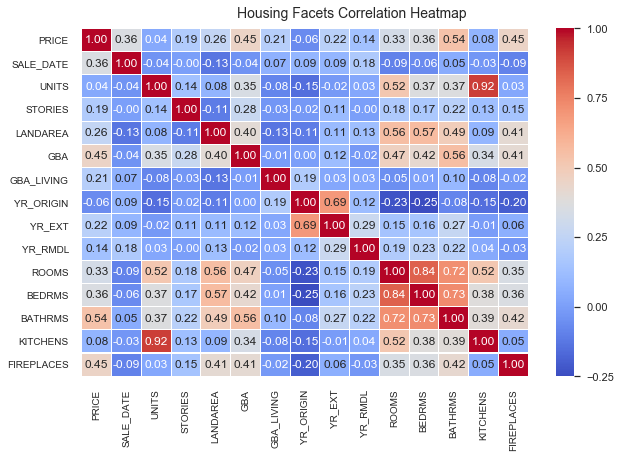

In [270]:
# HEATMAP

f, ax = plt.subplots(figsize=(10, 6))
corr = num_df.corr()
sns.set()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Housing Facets Correlation Heatmap', fontsize=14)

#### Potential variables to drop
* kitchen and units .92
* bedrooms and room .84
* bathrooms and bedrooms .73
* bathrooms and rooms .72
* yr_origin and yr_ext .69
* bathrooms and GBA .56
* bedrooms and landarea .57
* rooms and landarea .56
* units and room .52
* kitchens and room .52

In [271]:
# CENSUS_BLOCK and SQUARE are the most specific geographical facets. 
geo_facets = ['QUADRANT', 'WARD', 'NBHD', 'SUBNBHD', 'CENSUS_BLOCK', 'ZIPCODE', 'SQUARE']
for facet in geo_facets:
    print("The number of unique values in %s IS %f" % (facet, len(finaldf[facet].unique())))

The number of unique values in QUADRANT IS 4.000000
The number of unique values in WARD IS 8.000000
The number of unique values in NBHD IS 56.000000
The number of unique values in SUBNBHD IS 122.000000
The number of unique values in CENSUS_BLOCK IS 3756.000000
The number of unique values in ZIPCODE IS 24.000000
The number of unique values in SQUARE IS 3228.000000


## BASELINE MODEL:   
* dropped all geographical variables except SUBNBHD for relative specificity 
    * Training R^2: 0.7067
    * Testing R^2: 0.7177
    * Testing RMSE: 194645.07
    * MAPE: 41.41

In [272]:
subndf = scale_bin_df(dropdf, 'PRICE', ['QUADRANT', 'WARD', 'NBHD', 'CENSUS_BLOCK', 'ZIPCODE', 'SQUARE'])
subndf = subndf.drop(['EXTWALL_Plywood'], axis=1)  #removes glitch 
subndf.head()

,SALE_DATE,UNITS,STORIES,LANDAREA,GBA,GBA_LIVING,YR_ORIGIN,YR_EXT,YR_RMDL,ROOMS,BEDRMS,BATHRMS,KITCHENS,FIREPLACES,SALE_NUM_2_0,SALE_NUM_3_0,SALE_NUM_4_0,SALE_NUM_5_0,SALE_NUM_6_0,SALE_NUM_7_0,SALE_NUM_8_0,SALE_NUM_9_0,SALE_NUM_10_0,SALE_NUM_11_0,SALE_NUM_12_0,SALE_NUM_13_0,SALE_NUM_14_0,SALE_NUM_15_0,QUALIFIED_U,SUBNBHD_001_B_American_University,SUBNBHD_001_C_American_University,SUBNBHD_002_A_Anacostia,SUBNBHD_002_B_Anacostia,SUBNBHD_004_A_Berkley,SUBNBHD_004_B_Berkley,SUBNBHD_004_C_Berkley,SUBNBHD_005_A_Brentwood,SUBNBHD_005_B_Brentwood,SUBNBHD_006_A_Brightwood,SUBNBHD_006_B_Brightwood,SUBNBHD_006_C_Brightwood,SUBNBHD_006_D_Brightwood,SUBNBHD_006_E_Brightwood,SUBNBHD_007_A_Brookland,SUBNBHD_007_B_Brookland,SUBNBHD_007_C_Brookland,SUBNBHD_007_D_Brookland,SUBNBHD_007_E_Brookland,SUBNBHD_008_A_Burleith,SUBNBHD_008_B_Burleith,SUBNBHD_009_A_Capitol_Hill,SUBNBHD_009_B_Capitol_Hill,SUBNBHD_009_C_Capitol_Hill,SUBNBHD_011_A_Chevy_Chase,SUBNBHD_011_B_Chevy_Chase,SUBNBHD_011_C_Chevy_Chase,SUBNBHD_011_D_Chevy_Chase,SUBNBHD_011_E_Chevy_Chase,SUBNBHD_015_A_Columbia_Heights,SUBNBHD_015_B_Columbia_Heights,SUBNBHD_015_C_Columbia_Heights,SUBNBHD_015_D_Columbia_Heights,SUBNBHD_015_E_Columbia_Heights,SUBNBHD_016_A_Congress_Heights,SUBNBHD_016_B_Congress_Heights,SUBNBHD_016_C_Congress_Heights,SUBNBHD_018_A_Deanwood,SUBNBHD_018_B_Deanwood,SUBNBHD_018_C_Deanwood,SUBNBHD_018_D_Deanwood,SUBNBHD_018_E_Deanwood,SUBNBHD_019_A_Eckington,SUBNBHD_019_B_Eckington,SUBNBHD_022_A_Fort_Dupont_Park,SUBNBHD_022_B_Fort_Dupont_Park,SUBNBHD_022_C_Fort_Dupont_Park,SUBNBHD_022_D_Fort_Dupont_Park,SUBNBHD_025_A_Georgetown,SUBNBHD_025_B_Georgetown,SUBNBHD_025_C_Georgetown,SUBNBHD_025_D_Georgetown,SUBNBHD_025_E_Georgetown,SUBNBHD_025_F_Georgetown,SUBNBHD_025_G_Georgetown,SUBNBHD_025_H_Georgetown,SUBNBHD_025_I_Georgetown,SUBNBHD_025_J_Georgetown,SUBNBHD_028_A_Hillcrest,SUBNBHD_028_B_Hillcrest,SUBNBHD_028_C_Hillcrest,SUBNBHD_029_A_Kalorama,SUBNBHD_029_B_Kalorama,SUBNBHD_029_C_Kalorama,SUBNBHD_030_A_Kent,SUBNBHD_030_B_Kent,SUBNBHD_030_C_Kent,SUBNBHD_031_A_Ledroit_Park,SUBNBHD_031_B_Ledroit_Park,SUBNBHD_032_A_Lily_Ponds,SUBNBHD_032_B_Lily_Ponds,SUBNBHD_033_A_Marshall_Heights,SUBNBHD_033_B_Marshall_Heights,SUBNBHD_036_A_Mt__Pleasant,SUBNBHD_036_B_Mt__Pleasant,SUBNBHD_036_C_Mt__Pleasant,SUBNBHD_039_A_Old_City_1,SUBNBHD_039_B_Old_City_1,SUBNBHD_039_C_Old_City_1,SUBNBHD_039_D_Old_City_1,SUBNBHD_039_E_Old_City_1,SUBNBHD_039_F_Old_City_1,SUBNBHD_039_G_Old_City_1,SUBNBHD_039_H_Old_City_1,SUBNBHD_039_J_Old_City_1,SUBNBHD_039_K_Old_City_1,SUBNBHD_039_L_Old_City_1,SUBNBHD_039_M_Old_City_1,SUBNBHD_040_A_Old_City_2,SUBNBHD_040_B_Old_City_2,SUBNBHD_040_C_Old_City_2,SUBNBHD_040_D_Old_City_2,SUBNBHD_040_E_Old_City_2,SUBNBHD_040_F_Old_City_2,SUBNBHD_040_G_Old_City_2,SUBNBHD_041_A_Palisades,SUBNBHD_041_B_Palisades,SUBNBHD_042_A_Petworth,SUBNBHD_042_B_Petworth,SUBNBHD_042_C_Petworth,SUBNBHD_043_A_Randle_Heights,SUBNBHD_043_B_Randle_Heights,SUBNBHD_043_C_Randle_Heights,SUBNBHD_043_D_Randle_Heights,SUBNBHD_049_A_16th_Street_Heights,SUBNBHD_049_B_16th_Street_Heights,SUBNBHD_049_C_16th_Street_Heights,SUBNBHD_050_A_Spring_Valley,SUBNBHD_050_B_Spring_Valley,SUBNBHD_050_C_Spring_Valley,SUBNBHD_050_D_Spring_Valley,SUBNBHD_052_A_Trinidad,SUBNBHD_052_B_Trinidad,SUBNBHD_052_C_Trinidad,SUBNBHD_054_A_Wesley_Heights,SUBNBHD_054_B_Wesley_Heights,SUBNBHD_056_A_Woodridge,SUBNBHD_056_B_Woodridge,SUBNBHD_056_C_Woodridge,SUBNBHD_056_D_Woodridge,SUBNBHD_Southwest_Waterfront,STYLE_1_5_Story_Fin,STYLE_1_5_Story_Unfin,STYLE_2_Story,STYLE_2_5_Story_Fin,STYLE_2_5_Story_Unfin,STYLE_3_Story,STYLE_3_5_Story_Fin,STYLE_3_5_Story_Unfin,STYLE_4_Story,STYLE_4_5_Story_Fin,STYLE_4_5_Story_Unfin,STYLE_Bi_Level,STYLE_Default,STYLE_Outbuildings,STYLE_Split_Foyer,STYLE_Split_Level,STYLE_Vacant,STRUCT_Row_End,STRUCT_Row_Inside,STRUCT_Semi_Detached,STRUCT_Single,STRUCT_Town_End,STRUCT_Town_Inside,USECODE_12_0,USECODE_13_0,USECODE_15_0,USECODE_16_0,USECODE_17_0,USECODE_19_0,USECODE_23_0,USECODE_24_0,USECODE_39_0,USECODE_116_0,USECODE_

In [273]:
# regression function with sklearn using train/test:
X = subndf.drop(['PRICE'], axis=1).values
y = subndf['PRICE'].values
linreg(X, y, 'standard')

Training R^2: 0.7067
Testing R^2: 0.7177
Testing RMSE: 194645.07
MAPE: 41.41


### LOG 10 Regression with ridge works better

In [274]:
ylog10 = [math.log10(i) for i in subndf['PRICE'].values]

X = subndf.drop(['PRICE'], axis=1).values
y = ylog10
ridgereg(X, y, 'log')

Training RIDGE R^2: 0.7650
Testing RIDGE R^2: 0.7517
Tuned RIDGE alpha: {'alpha': 0.2222222222222222}
Testing RMSE: 198741.51
MAPE: 28.84


In [275]:
# regression using statsmodels
y = ylog10
X = subndf.drop('PRICE', axis=1)

X = sm.add_constant(X)
model_fit = sm.OLS(y, X).fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                     1158.
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        19:52:47   Log-Likelihood:                 40101.
No. Observations:               96124   AIC:                        -7.967e+04
Df Residuals:                   95859   BIC:                        -7.716e+04
Df Model:                         264                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 5.8990      0.083     70.784      0.000       5.736       6.062
SALE_DATE                             0.1788      0.001    223.247      0.000       0.177       0.180
UNITS                                -0.0080      0.002     -4.787      0.000      -0.011      -0.005
STORIES                              -0.0003      0.001     -0.346      0.729      -0.002       0.001
LANDAREA                              0.0078      0.001      6.861      0.000       0.006       0.010
GBA                                   0.0267      0.001     25.650      0.000       0.025       0.029
GBA_LIVING                            0.0804      0.001    115.902      0.000       0.079       0.082
YR_ORIGIN                            -0.0173      0.001    -13.152      0.000      -0.020      -0.015
YR_EXT                                0.0244      0.001     20.561      0.000       0.022       0.027
YR_RMDL                               0.0131      0.001     21.143      0.000       0.012       0.014
ROOMS                                 0.0058      0.001      4.510      0.000       0.003       0.008
BEDRMS                                0.0103      0.001      8.714      0.000       0.008       0.013
BATHRMS                               0.0320      0.001     31.251      0.000       0.030       0.034
KITCHENS                              0.0026      0.001      1.980      0.048    2.68e-05       0.005
FIREPLACES                            0.0173      0.001     24.312      0.000       0.016       0.019
SALE_NUM_2_0                         -0.0648      0.002    -29.967      0.000      -0.069      -0.061
SALE_NUM_3_0                         -0.0667      0.002    -33.277      0.000      -0.071      -0.063
SALE_NUM_4_0                         -0.0665      0.002    -29.570      0.000      -0.071      -0.062
SALE_NUM_5_0                         -0.0635      0.003    -21.374      0.000      -0.069      -0.058
SALE_NUM_6_0                         -0.0646      0.004    -15.114      0.000      -0.073      -0.056
SALE_NUM_7_0                         -0.0723      0.007    -10.182      0.000      -0.086      -0.058
SALE_NUM_8_0                         -0.0707      0.011     -6.192      0.000      -0.093      -0.048
SALE_NUM_9_0                         -0.0626      0.017     -3.680      0.000      -0.096      -0.029
SALE_NUM_10_0                        -0.0210      0.031     -0.682      0.495      -0.081       0.039
SALE_NUM_11_0                         0.0118      0.046      0.254      0.799      -0.079       0.102
SALE_NUM_12_0                        -0.0244      0.065     -0.374      0.708      -0.152       0.104
SALE_NUM_13_0                        -0.1371      0.092     -1.485      0.138      -0.318       0.044
SALE_NUM_14_0          

#### VIF: EXTWALL, HEAT, and AC create the most variance

In [276]:
logdf = subndf.copy()
log_prices = [math.log10(i) for i in subndf['PRICE']]
logdf['PRICE'] = log_prices
vif = vif_scores(logdf, 'PRICE')
vif

,VIF Factor,features
248,2444.737254,EXTWALL_Common_Brick
206,1118.212376,HEAT_Forced_Air
208,834.172611,HEAT_Hot_Water_Rad
245,685.191375,EXTWALL_Brick_Siding
213,670.612976,HEAT_Warm_Cool
209,660.428866,HEAT_Ht_Pump
263,615.828111,EXTWALL_Vinyl_Siding
215,451.356465,AC_N
216,450.929043,AC_Y
264,435.605702,EXTWALL_Wood_Siding


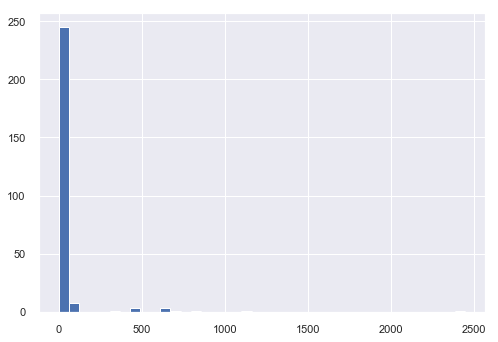

In [277]:
sns.set()
plt.hist(vif['VIF Factor'], bins=40)
plt.show()

In [278]:
high_vif = list(vif[vif['VIF Factor'] > 400]['features'])
high_vif

['EXTWALL_Common_Brick',
 'HEAT_Forced_Air',
 'HEAT_Hot_Water_Rad',
 'EXTWALL_Brick_Siding',
 'HEAT_Warm_Cool',
 'HEAT_Ht_Pump',
 'EXTWALL_Vinyl_Siding',
 'AC_N',
 'AC_Y',
 'EXTWALL_Wood_Siding']

### Graphs from statsmodels linear regression

(0, 20000)

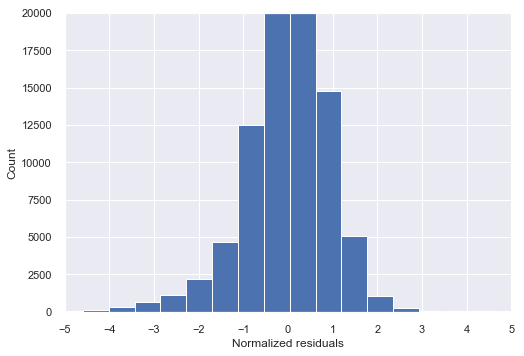

In [279]:
plt.hist(model_fit.resid_pearson, bins=30)
plt.ylabel('Count')
plt.xlabel('Normalized residuals')
plt.xlim(-5, 5)
plt.xticks(range(-5, 6))
plt.ylim(0, 20000)

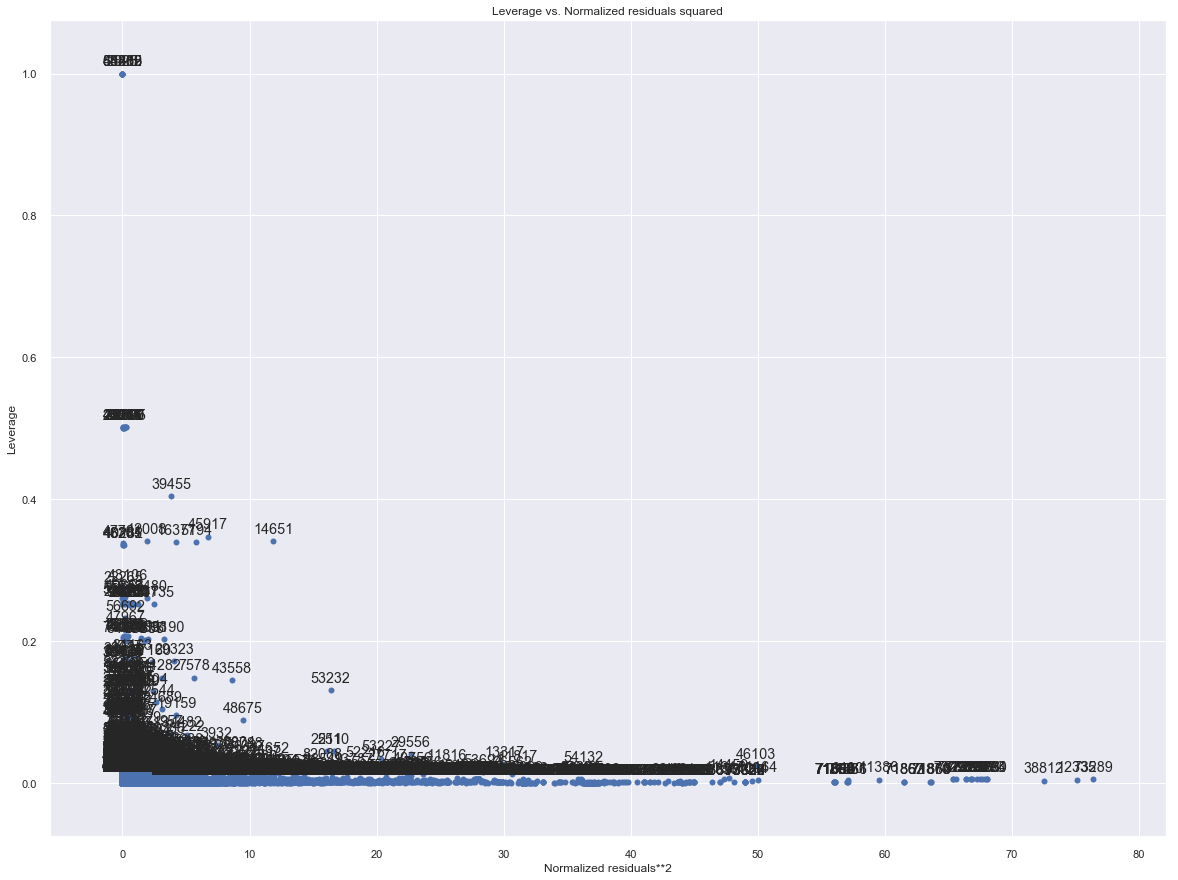

In [280]:
from statsmodels.graphics.regressionplots import *
import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(20,15))
    mpl.rc("xlim", )
    plot_leverage_resid2(model_fit)


# OPTIMIZED MODEL, ALL DATA:
*  KITCHENS REMOVED (high colinearity)
*  HIGH DIMENSIONAL GEOGRAPHICAL VARIABLES REMOVED (SUBNBHD, CENSUS_BLOCK, SQUARE)
*  Performed best with log 10 ridge regression: 
    * Mean Absolute Percentage Error: 27.48
    * Tuned Ridge alpha: {'alpha': .22}
    * R^2 for testing:  0.7702
    * Root mean squared error: 191419.47

In [281]:
# best variables 
maxdf = scale_bin_df(dropdf, 'PRICE', ['KITCHENS', 'SUBNBHD', 'CENSUS_BLOCK', 'SQUARE'])

log_prices = [math.log10(i) for i in maxdf['PRICE']]
maxdf['PRICE'] = log_prices

X = maxdf.drop(['PRICE'], axis=1).values
y = maxdf['PRICE'].values
     
ridgereg(X, y, 'log')

Training RIDGE R^2: 0.7816
Testing RIDGE R^2: 0.7702
Tuned RIDGE alpha: {'alpha': 1.0}
Testing RMSE: 191419.47
MAPE: 27.48


#### We can check if our model matches assumptions of linear regression:
    * linear
    * normal distribution (fail, long tails)
    * homoscedastic (fail)

In [282]:
# sample regression using statsmodels
sampledf = maxdf.copy()

y = sampledf['PRICE']
X = sampledf.drop('PRICE', axis=1)

X = sm.add_constant(X)
sample_model = sm.OLS(y, X).fit()

In [283]:
# fitted values (need a constant term for intercept)
model_fitted_y = sample_model.fittedvalues

# model residuals
model_residuals = sample_model.resid

# normalized residuals
model_norm_residuals = sample_model.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = sample_model.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = sample_model.get_influence().cooks_distance[0]


/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [284]:
# Graph styles:
from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

Text(0, 0.5, 'Residuals')

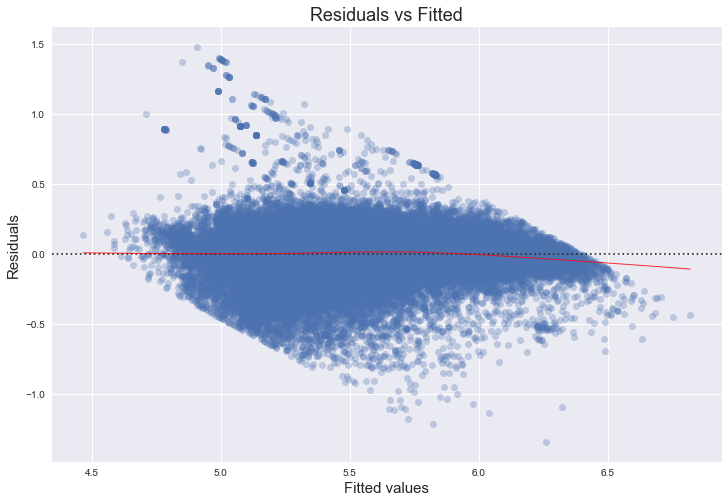

In [285]:
# Residuals versus Fitted
# data is linear (average is 0)
# data is somewhat heterskedastic (uneven distribution from left to right)
y = sampledf['PRICE']
X = sampledf.drop('PRICE', axis=1)
model_fitted_y = sample_model.fittedvalues

plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, y, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.3}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')


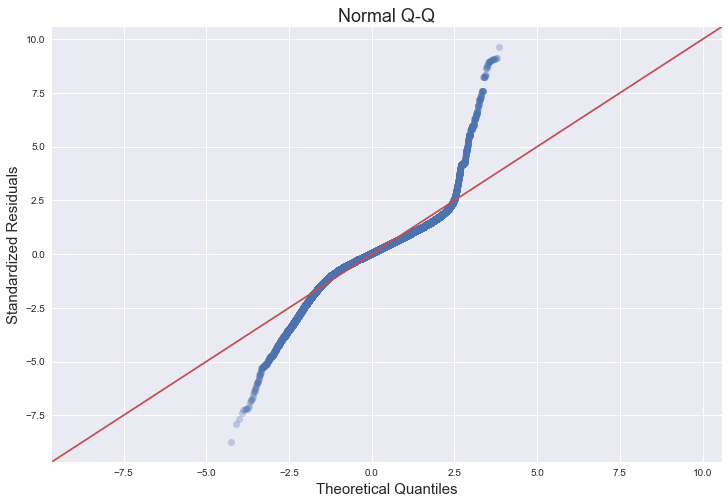

In [286]:
# Normal Q-Q Plot, test for normal distribution of residuals
# large tails

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.3, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');


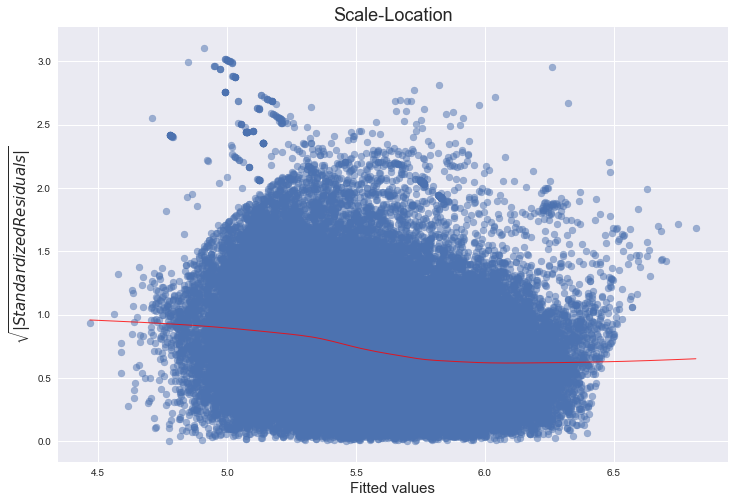

In [287]:
# Scale - Location, test for homoskedasticity, equal spread of residual variance
# Fails. Higher residuals for lower values
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.5)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, "LOG('PRICE') Values, Observed Versus Predicted")

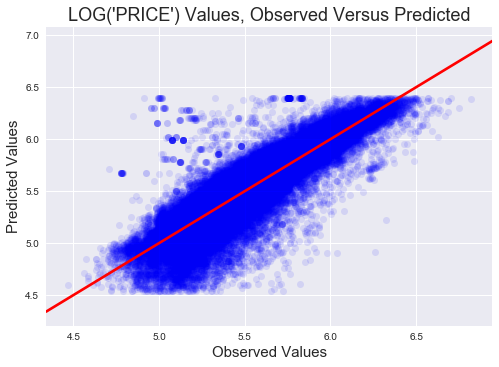

In [288]:
sns.regplot(model_fitted_y, y, scatter_kws={'alpha':0.1, 'color':'blue'}, color='red')
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("LOG('PRICE') Values, Observed Versus Predicted")

# EXAMINING OUTLIERS:

In [289]:
# wanted studentized resid because it's a better method (.resid_studentized_external), but it wouldn't run
# used standardized residuals instead
y = maxdf['PRICE']
X = maxdf.drop('PRICE', axis=1)

X = sm.add_constant(X)
model_fit = sm.OLS(y, X).fit()

copydf = dropdf.copy()
log_prices = [math.log10(i) for i in copydf['PRICE']]
copydf['PRICE'] = log_prices

high_studentized_resid = np.where(np.absolute(model_fit.get_influence().resid_studentized_internal) > 3)

no_outdf = copydf.drop(high_studentized_resid[0])
outdf = copydf.iloc[high_studentized_resid[0]]
print(np.round(outdf.shape[0] / copydf.shape[0] * 100, 3), "percent of data was classified as an outlier." )
outdf.head()


1.659 percent of data was classified as an outlier.


/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


,PRICE,SALE_DATE,SALE_NUM,QUALIFIED,QUADRANT,WARD,SQUARE,NBHD,SUBNBHD,CENSUS_BLOCK,ZIPCODE,STYLE,STRUCT,USECODE,UNITS,STORIES,GRADE,CNDTN,LANDAREA,GBA,GBA_LIVING,YR_ORIGIN,YR_EXT,YR_RMDL,ROOMS,BEDRMS,BATHRMS,KITCHENS,HEAT,AC,FIREPLACES,ROOF,INTWALL,EXTWALL
14,5.115611,9.227700e+08,1.0,Q,NW,Ward 2,208,Old City 2,040 E Old City 2,0052014003,20009.0,3 Story,Row Inside,11.0,1.0,3.0,Good Quality,Good,1853.0,2568.0,700.0,1890.0,1960.0,2004.0,6.0,2.0,2.5,1.0,Forced Air,Y,3.0,Metal- Sms,Hardwood,Common Brick
188,5.243398,1.438574e+09,5.0,U,NW,Ward 1,234,Old City 2,040 F Old City 2,0044001005,20009.0,2 Story,Row Inside,11.0,1.0,2.0,Above Average,Average,1760.0,1496.0,700.0,1895.0,1967.0,2009.0,8.0,3.0,2.0,1.0,Forced Air,Y,1.0,Built Up,Hardwood,Common Brick
192,5.332438,1.013058e+09,1.0,Q,NW,Ward 1,234,Old City 2,040 F Old City 2,0044001005,20009.0,2 Story,Row End,24.0,2.0,2.0,Good Quality,Good,2970.0,2650.0,700.0,1895.0,1960.0,2003.0,6.0,4.0,4.0,2.0,Hot Water Rad,Y,2.0,Built Up,Hardwood,Common Brick
357,5.000000,1.133327e+09,1.0,U,NW,Ward 1,237,Old City 2,040 E Old City 2,0044002008,20009.0,3 Story,Row Inside,11.0,1.0,3.0,Good Quality,Average,1800.0,2888.0,700.0,1900.0,1967.0,2007.0,8.0,4.0,3.5,1.0,Hot Water Rad,N,4.0,Built Up,Hardwood,Common Brick
376,4.653213,1.052280e+09,1.0,U,NW,Ward 2,190,Old City 2,040 E Old City 2,0043002002,20009.0,3 Story,Row Inside,11.0,1.0,3.0,Good Quality,Good,1400.0,2292.0,700.0,1885.0,1969.0,1988.0,9.0,4.0,2.0,1.0,Warm Cool,Y,2.0,Built Up,Hardwood,Common Brick


In [307]:
outdf

,PRICE,SALE_DATE,SALE_NUM,QUALIFIED,QUADRANT,WARD,SQUARE,NBHD,SUBNBHD,CENSUS_BLOCK,ZIPCODE,STYLE,STRUCT,USECODE,UNITS,STORIES,GRADE,CNDTN,LANDAREA,GBA,GBA_LIVING,YR_ORIGIN,YR_EXT,YR_RMDL,ROOMS,BEDRMS,BATHRMS,KITCHENS,HEAT,AC,FIREPLACES,ROOF,INTWALL,EXTWALL
14,5.115611,9.227700e+08,1.0,Q,NW,Ward 2,208,Old City 2,040 E Old City 2,0052014003,20009.0,3 Story,Row Inside,11.0,1.0,3.0,Good Quality,Good,1853.0,2568.0,700.0,1890.0,1960.0,2004.0,6.0,2.0,2.5,1.0,Forced Air,Y,3.0,Metal- Sms,Hardwood,Common Brick
188,5.243398,1.438574e+09,5.0,U,NW,Ward 1,234,Old City 2,040 F Old City 2,0044001005,20009.0,2 Story,Row Inside,11.0,1.0,2.0,Above Average,Average,1760.0,1496.0,700.0,1895.0,1967.0,2009.0,8.0,3.0,2.0,1.0,Forced Air,Y,1.0,Built Up,Hardwood,Common Brick
192,5.332438,1.013058e+09,1.0,Q,NW,Ward 1,234,Old City 2,040 F Old City 2,0044001005,20009.0,2 Story,Row End,24.0,2.0,2.0,Good Quality,Good,2970.0,2650.0,700.0,1895.0,1960.0,2003.0,6.0,4.0,4.0,2.0,Hot Water Rad,Y,2.0,Built Up,Hardwood,Common Brick
357,5.000000,1.133327e+09,1.0,U,NW,Ward 1,237,Old City 2,040 E Old City 2,0044002008,20009.0,3 Story,Row Inside,11.0,1.0,3.0,Good Quality,Average,1800.0,2888.0,700.0,1900.0,1967.0,2007.0,8.0,4.0,3.5,1.0,Hot Water Rad,N,4.0,Built Up,Hardwood,Common Brick
376,4.653213,1.052280e+09,1.0,U,NW,Ward 2,190,Old City 2,040 E Old City 2,0043002002,20009.0,3 Story,Row Inside,11.0,1.0,3.0,Good Quality,Good,1400.0,2292.0,700.0,1885.0,1969.0,1988.0,9.0,4.0,2.0,1.0,Warm Cool,Y,2.0,Built Up,Hardwood,Common Brick
461,4.903090,9.270000e+08,1.0,U,NW,Ward 2,190,Old City 2,040 E Old City 2,0043002002,20009.0,3 Story,Row Inside,11.0,1.0,3.0,Good Quality,Average,1440.0,2154.0,700.0,1885.0,1967.0,2007.0,9.0,6.0,1.0,1.0,Hot Water Rad,N,0.0,Built Up,Wood Floor,Common Brick
517,4.982090,7.957620e+08,1.0,U,NW,Ward 2,242,Old City 2,040 E Old City 2,0050022000,20005.0,3 Story,Row Inside,24.0,2.0,3.0,Very Good,Average,1384.0,4045.0,700.0,1895.0,1963.0,1985.0,14.0,6.0,5.0,2.0,Forced Air,Y,4.0,Metal- Sms,Hardwood,Common Brick
518,5.301030,1.294636e+09,1.0,U,NW,Ward 2,243,Old City 2,040 C Old City 2,0050022002,20005.0,3 Story,Row Inside,24.0,4.0,3.0,Very Good,Average,1478.0,2280.0,700.0,1900.0,1963.0,1989.0,9.0,4.0,4.0,4.0,Warm Cool,Y,0.0,Built Up,Hardwood,Common Brick
568,4.886491,1.018325e+09,1.0,Q,NW,Ward 6,475,Old City 2,040 G Old City 2,0048011007,20001.0,2 Story,Row End,11.0,1.0,2.0,Average,Average,911.0,1204.0,700.0,1900.0,1961.0,2007.0,4.0,2.0,2.0,1.0,Hot Water Rad,Y,0.0,Metal- Sms,Wood Floor,Brick/Siding
638,4.698970,1.136783e+09,1.0,U,NW,Ward 1,360,Old City 2,040 F Old City 2,0044001014,20001.0,2 Story,Row Inside,11.0,1.0,2.0,Above Average,Fair,1248.0,1590.0,700.0,1910.0,1957.0,2006.0,6.0,3.0,1.0,1.0,Hot Water Rad,N,0.0,Metal- Sms,Wood Floor,Common Brick


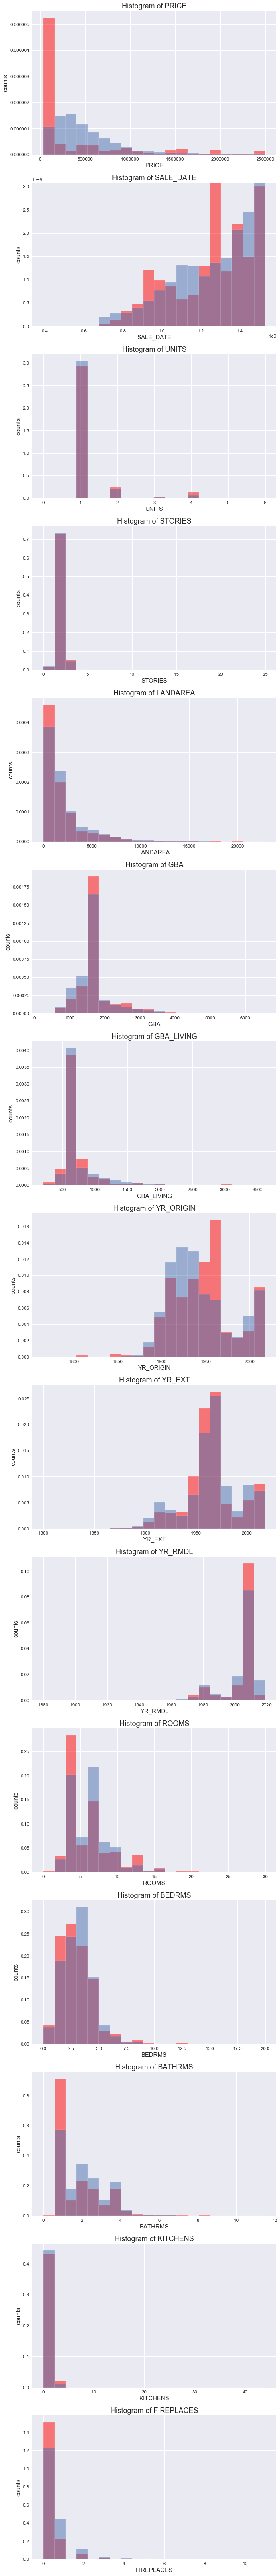

In [309]:
def hist_num(outdf, origdf):
    #selecting numerical cols
    num_list = list(outdf.loc[:, (outdf.dtypes == np.float64)].columns)
    outnumdf = outdf[num_list]
    orignumdf = origdf[num_list]
    
    #histograms for numerical facets
    fig, axs = plt.subplots(len(outnumdf.columns)-3,1, figsize=(10,6*len(outnumdf.columns)))
    plt.rc('xtick', labelsize='small') 
    plt.rc('ytick', labelsize='small') 
    for i, name in enumerate(num_list):
            plt.subplot(len(num_list), 1, i+1)
            a = plt.hist(outnumdf[name], alpha=.5, bins=20, \
                         range=(orignumdf[name].min(), orignumdf[name].max()), color='red', density=True)
            a = plt.hist(orignumdf[name], alpha=.5, bins=20, density=True)
            plt.xlabel(name)
            plt.ylabel('counts')
            plt.title("Histogram of %s" % name)  
    plt.tight_layout()

ylog10 = [math.log10(i) for i in subndf['PRICE'].values]
invlog_outdf = outdf.copy()
invlog_outdf['PRICE'] = np.array([math.exp(np.log(10)*i) for i in invlog_outdf.PRICE])
hist_num(invlog_outdf, dropdf)
                        

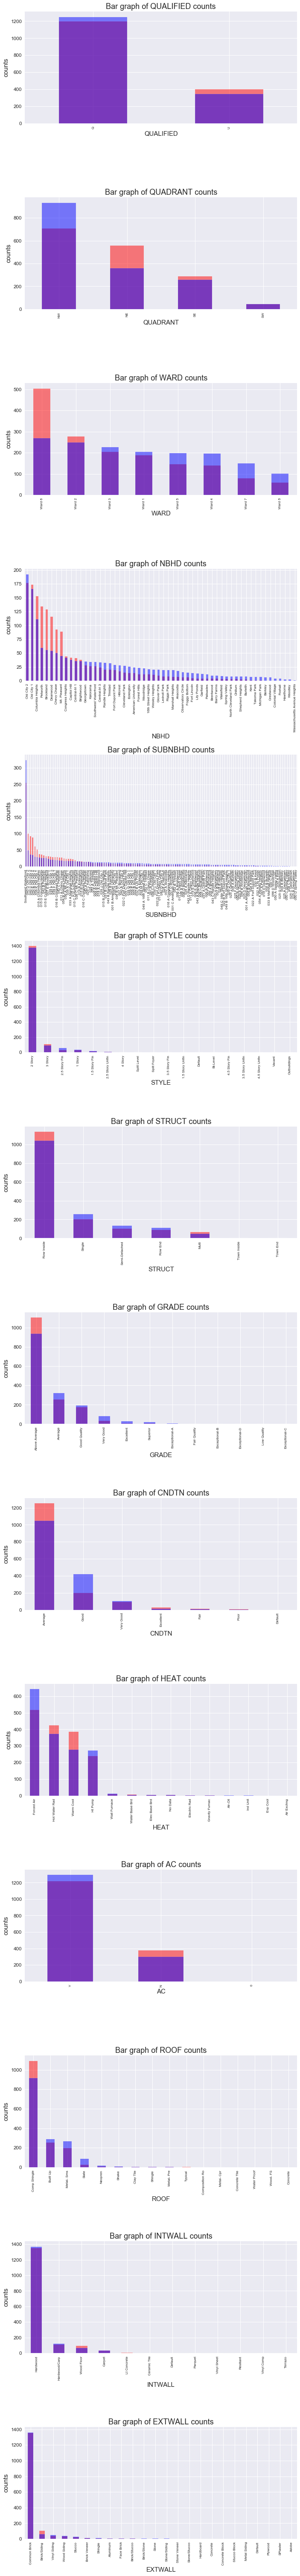

In [291]:
def bar_obj(df, origdf):
    scale = origdf.shape[0] / df.shape[0]
    #selecting numerical cols
    obj = list(outdf.select_dtypes(include=object).columns)
    gdf = df[obj]
    gdf2 = origdf[obj]
    
    #bar graphs for numerical facets
    fig, axs = plt.subplots(len(gdf.columns)-3,1, figsize=(10,6*len(gdf.columns)))
    plt.rc('xtick', labelsize='small') 
    plt.rc('ytick', labelsize='small') 
    for i, name in enumerate(obj):
            plt.subplot(len(obj), 1, i+1)
            a = gdf[name].value_counts().plot(kind='bar', title= name, alpha=.5, color='red')
            a = (gdf2[name].value_counts()/scale).plot(kind='bar', title= name, alpha=.5, color='blue')
            plt.xlabel(name)
            plt.ylabel('counts')
            plt.title("Bar graph of %s counts" % name) 
            plt.xticks(size='xx-small')
    plt.tight_layout()

bar_obj(outdf, dropdf)

### DESCRIBING OUTLIER OBSERVATIONS, COMPARED TO ORIGINAL:
    •	lower (or higher) prices
    •	sold during different times than original data
    •	lower (or higher) landarea
    •	more built in 1940s-1960s
    •	remodeled 2005-2015
    •	fewer rooms/bedrooms
    •	more in NE, Wards 2/6
    •	more in Columbia Heights, Petworth, Brookland, Dearwood, Chevy Chase, Mount Pleasant, Congress Heights  

# OPTIMIZED MODEL WITHOUT OUTLIERS:
* Performed best with ridge regression: 
    * dropped CENSUS_BLOCK, SQUARE, SUBNBHD, KITCHENS
    * Training RIDGE R^2: 0.8370
    * Testing RIDGE R^2: 0.8351
    * Tuned RIDGE alpha: {'alpha': 1.0}
    * Testing RMSE: 148619.06
    * MAPE: 23.73

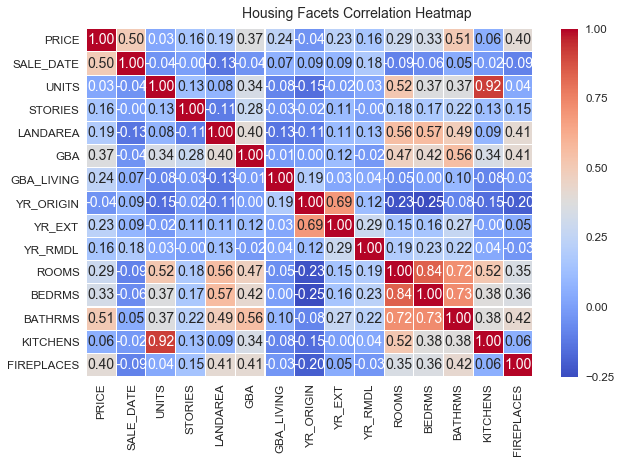

In [292]:
# HEATMAP
num_df = no_outdf.loc[:, (dropdf.dtypes == np.float64)]
num_df.drop('PRICE', axis=1)

f, ax = plt.subplots(figsize=(10, 6))
corr = num_df.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Housing Facets Correlation Heatmap', fontsize=14)

#### Colinear vars. Removing these did not improve RMSE on test data. 
* units / kitchens .92
* rooms / bedrooms .84
* bathrooms / bedrooms .73
* rooms / bathrooms .72
* yr_ext / yr_origin .69

In [293]:
sno_outdf = scale_bin_df(no_outdf, 'PRICE', ['KITCHENS', 'SUBNBHD', 'CENSUS_BLOCK', 'SQUARE'])
X = sno_outdf.drop(['PRICE'], axis=1).values
y = sno_outdf['PRICE'].values
ridgereg(X, y, 'log')

Training RIDGE R^2: 0.8370
Testing RIDGE R^2: 0.8351
Tuned RIDGE alpha: {'alpha': 1.0}
Testing RMSE: 148619.06
MAPE: 23.73


In [294]:
# regression using statsmodels
y = sno_outdf['PRICE']
X = sno_outdf.drop(['PRICE'], axis=1)

X = sm.add_constant(X)
sample_model = sm.OLS(y, X).fit()
sample_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PRICE   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     2100.
Date:                Sun, 02 Jun 2019   Prob (F-statistic):               0.00
Time:                        20:49:00   Log-Likelihood:                 60316.
No. Observations:               94529   AIC:                        -1.202e+05
Df Residuals:                   94298   BIC:                        -1.180e+05
Df Model:                         230                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 5.5553      0.134     41.499      0.000       5.293       5.818
SALE_DATE                             0.1762      0.001    272.010      0.000       0.175       0.177
UNITS                                -0.0040      0.001     -3.884      0.000      -0.006      -0.002
STORIES                             6.34e-06      0.001      0.009      0.993      -0.001       0.001
LANDAREA                              0.0125      0.001     13.387      0.000       0.011       0.014
GBA                                   0.0269      0.001     32.299      0.000       0.025       0.029
GBA_LIVING                            0.0817      0.001    144.530      0.000       0.081       0.083
YR_ORIGIN                            -0.0031      0.001     -2.921      0.003      -0.005      -0.001
YR_EXT                                0.0183      0.001     19.199      0.000       0.016       0.020
YR_RMDL                               0.0138      0.001     27.240      0.000       0.013       0.015
ROOMS                                 0.0068      0.001      6.585      0.000       0.005       0.009
BEDRMS                                0.0164      0.001     17.184      0.000       0.015       0.018
BATHRMS                               0.0267      0.001     32.378      0.000       0.025       0.028
FIREPLACES                            0.0172      0.001     30.103      0.000       0.016       0.018
SALE_NUM_2_0                         -0.0519      0.002    -29.710      0.000      -0.055      -0.048
SALE_NUM_3_0                         -0.0600      0.002    -37.047      0.000      -0.063      -0.057
SALE_NUM_4_0                         -0.0626      0.002    -34.446      0.000      -0.066      -0.059
SALE_NUM_5_0                         -0.0628      0.002    -26.222      0.000      -0.068      -0.058
SALE_NUM_6_0                         -0.0671      0.003    -19.437      0.000      -0.074      -0.060
SALE_NUM_7_0                         -0.0682      0.006    -11.893      0.000      -0.079      -0.057
SALE_NUM_8_0                         -0.0583      0.009     -6.283      0.000      -0.076      -0.040
SALE_NUM_9_0                         -0.0472      0.014     -3.399      0.001      -0.074      -0.020
SALE_NUM_10_0                        -0.0240      0.025     -0.972      0.331      -0.072       0.024
SALE_NUM_11_0                        -0.0166      0.037     -0.448      0.654      -0.089       0.056
SALE_NUM_12_0                        -0.0490      0.052     -0.938      0.348      -0.152       0.053
SALE_NUM_13_0                        -0.1458      0.074     -1.971      0.049      -0.291      -0.001
SALE_NUM_14_0                        -0.0508      0.091     -0.560      0.575      -0.228       0.127
SALE_NUM_15_0          

### Graphs for further examination.
* We can check if our model matches assumptions of linear regression:
    * linear (fail)
    * normal distribution (fail)
    * homoskedasticity (fail)
* We will use nonlinear models (Random Forest) as an alternative

In [295]:
# fitted values (need a constant term for intercept)
model_fitted_y = sample_model.fittedvalues

# model residuals
model_residuals = sample_model.resid

# normalized residuals
model_norm_residuals = sample_model.get_influence().resid_studentized_internal

# absolute squared normalized residuals
model_norm_residuals_abs_sqrt = np.sqrt(np.abs(model_norm_residuals))

# absolute residuals
model_abs_resid = np.abs(model_residuals)

# leverage, from statsmodels internals
model_leverage = sample_model.get_influence().hat_matrix_diag

# cook's distance, from statsmodels internals
model_cooks = sample_model.get_influence().cooks_distance[0]

/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:323: RuntimeWarning: invalid value encountered in sqrt
  return  self.results.resid / sigma / np.sqrt(1 - hii)
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [296]:
# Graph styles:
from statsmodels.graphics.gofplots import ProbPlot

plt.style.use('seaborn') # pretty matplotlib plots

plt.rc('font', size=14)
plt.rc('figure', titlesize=18)
plt.rc('axes', labelsize=15)
plt.rc('axes', titlesize=18)

Text(0, 0.5, 'Residuals')

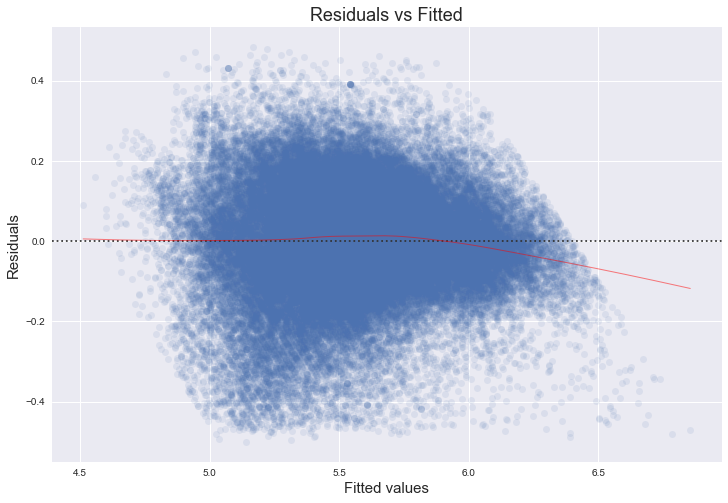

In [297]:
# Residuals versus Fitted, test for linear data
y = sno_outdf['PRICE']
X = sno_outdf.drop(['PRICE'], axis=1)
model_fitted_y = sample_model.fittedvalues

plot_lm_1 = plt.figure(1)
plot_lm_1.set_figheight(8)
plot_lm_1.set_figwidth(12)

plot_lm_1.axes[0] = sns.residplot(model_fitted_y, y, 
                          lowess=True, 
                          scatter_kws={'alpha': 0.1}, 
                          line_kws={'color': 'red', 'lw': 1, 'alpha': 0.5})

plot_lm_1.axes[0].set_title('Residuals vs Fitted')
plot_lm_1.axes[0].set_xlabel('Fitted values')
plot_lm_1.axes[0].set_ylabel('Residuals')

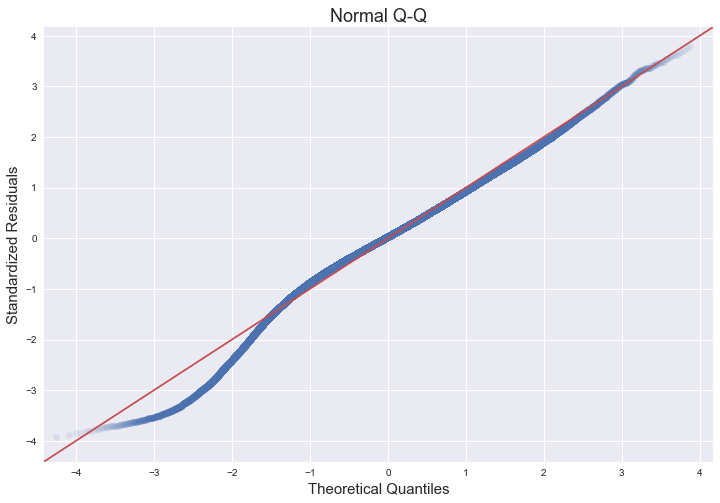

In [298]:
# Normal Q-Q Plot, test for normal distribution of residuals
# large tails

QQ = ProbPlot(model_norm_residuals)
plot_lm_2 = QQ.qqplot(line='45', alpha=0.1, color='#4C72B0', lw=1)

plot_lm_2.set_figheight(8)
plot_lm_2.set_figwidth(12)

plot_lm_2.axes[0].set_title('Normal Q-Q')
plot_lm_2.axes[0].set_xlabel('Theoretical Quantiles')
plot_lm_2.axes[0].set_ylabel('Standardized Residuals');


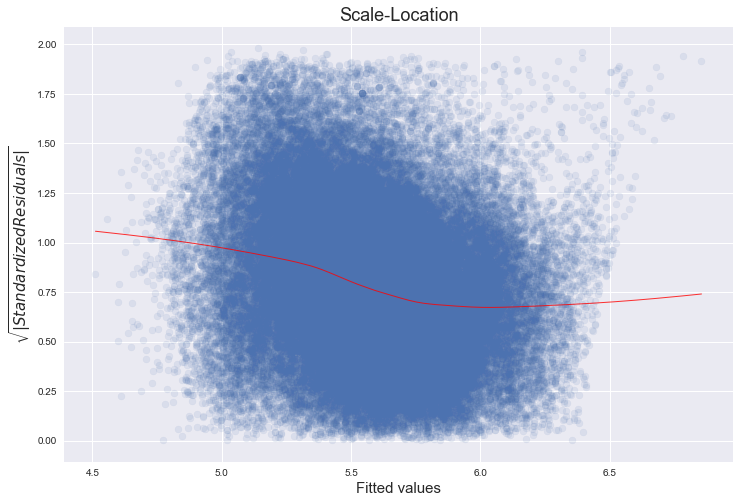

In [299]:
# Scale - Location, test for homoskedasticity, equal spread of residual variance
# Fails. Lower residuals for lower values
plot_lm_3 = plt.figure(3)
plot_lm_3.set_figheight(8)
plot_lm_3.set_figwidth(12)

plt.scatter(model_fitted_y, model_norm_residuals_abs_sqrt, alpha=0.1)
sns.regplot(model_fitted_y, model_norm_residuals_abs_sqrt, 
            scatter=False, 
            ci=False, 
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

plot_lm_3.axes[0].set_title('Scale-Location')
plot_lm_3.axes[0].set_xlabel('Fitted values')
plot_lm_3.axes[0].set_ylabel('$\sqrt{|Standardized Residuals|}$');

/Users/Julia/miniconda3/envs/advanced-pip-example/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, "LOG('PRICE') Values, Observed Versus Predicted, No Outliers")

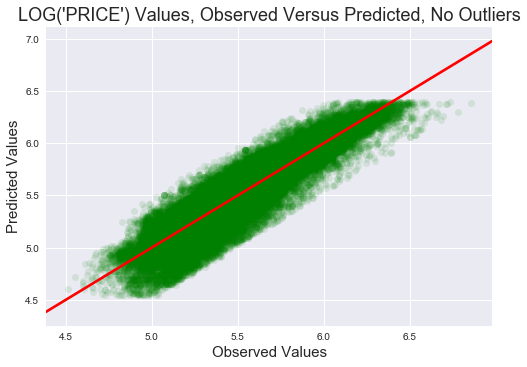

In [300]:
sns.regplot(model_fitted_y, y, scatter_kws={'alpha':0.1, 'color':'green'}, color='red')
plt.xlabel("Observed Values")
plt.ylabel("Predicted Values")
plt.title("LOG('PRICE') Values, Observed Versus Predicted, No Outliers")

# SUMMARY:
    
## OPTIMIZED MODEL, ALL DATA:
*  Performed best with ridge regression: 
    * dropped KITCHENS (high colinearity)
    * dropped high dimensional geographical variables (SUBNBHD, CENSUS_BLOCK, SQUARE)
    * Mean Absolute Percentage Error: 27.48
    * R^2 for testing: 0.7702
    * Root mean squared error: 191419.47
    
## OPTIMIZED MODEL WITHOUT OUTLIERS:
* Performed best with ridge regression: 
    * dropped high dimensional geographical variables (CENSUS_BLOCK and SQUARE)
    * Mean Absolute Percentage Error: 23.73
    * Tuned Ridge R squared: 0.8351
    * Tuned Ridge RMSE: 148619.06
    * Percentage of data remove as outliers: 1.7%